In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import mlflow.lightgbm
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
from IPython.display import Image


Let the fun begin.


In [2]:
df = pd.read_csv("../data/CRIME_DATA_WITH_MICE_IMPUTED_DEMOGRAPHICS.csv")


In [5]:
df.columns


Index(['Unnamed: 0', 'Description', 'Post', 'District', 'Neighborhood',
       'Longitude', 'Latitude', 'Premise', 'Month', 'Hour', 'Year',
       'median_household_income', 'households_below_poverty', 'perc18_24',
       'perc25_64', 'perc65up', 'perc_asian', 'perc_aa', 'perc_hisp',
       'perc_white', 'median_price_homes_sold', 'racial_diversity_index',
       'num_households', 'Outside', 'Weapon_FIREARM', 'Weapon_HANDS',
       'Weapon_KNIFE', 'Weapon_NONE', 'Weapon_OTHER', 'Season_autumn',
       'Season_spring', 'Season_summer', 'Season_winter', 'Holiday',
       'Weekend'],
      dtype='object')

In [3]:
df = df.drop(columns=["Unnamed: 0", "Post", "District", "Longitude", "Latitude", "Year", "Season_autumn", "Season_spring", "Season_summer", "Season_winter"])

In [8]:
df.columns


Index(['Description', 'Neighborhood', 'Premise', 'Month', 'Hour',
       'median_household_income', 'households_below_poverty', 'perc18_24',
       'perc25_64', 'perc65up', 'perc_asian', 'perc_aa', 'perc_hisp',
       'perc_white', 'median_price_homes_sold', 'racial_diversity_index',
       'num_households', 'Outside', 'Weapon_FIREARM', 'Weapon_HANDS',
       'Weapon_KNIFE', 'Weapon_NONE', 'Weapon_OTHER', 'Holiday', 'Weekend'],
      dtype='object')

In [4]:
X = df.drop(columns = ['Description'])
Y = df['Description']


In [10]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 20,1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 4, 200, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50,1)),
    'reg_alpha': hp.loguniform('reg_l1', -6, 7),
    'min_child_weight': hp.uniform('min_child_weight', 0, 1),
    'min_child_samples': scope.int(hp.quniform('min_child_samples',4,30,1)),
    'objective': "multiclass",
    "random_state": 42069,
    "n_jobs": -1,
    "silent": True,
    "num_class": 15,
    "boosting": hp.choice("boosting",["gbdt", "dart", "goss"])
}


In [11]:
def train_model(params):
    mlflow.lightgbm.autolog()
    with mlflow.start_run(nested=True):
        booster = lgb.LGBMClassifier()
        booster.set_params(**params)
        booster.fit(X,Y)

        mlflow.log_params(params)

        score = cross_val_score(booster, X, Y, cv=5, scoring='f1_macro', n_jobs=-1)
        mean_score = np.mean(score)

        mlflow.log_metric('f1_macro', mean_score)

        return {'status': STATUS_OK, 'loss': -1*mean_score, 'booster': booster.get_params()}


In [12]:
with mlflow.start_run(run_name='lightgbm_demo_1'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=25,
    trials=Trials(),
    rstate=np.random.RandomState(42069)
  )


[LightGBM] [Warning]                                  
boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
100%|██████████| 25/25 [20:18<00:00, 48.76s/trial, best loss: -0.3891631329793947] 


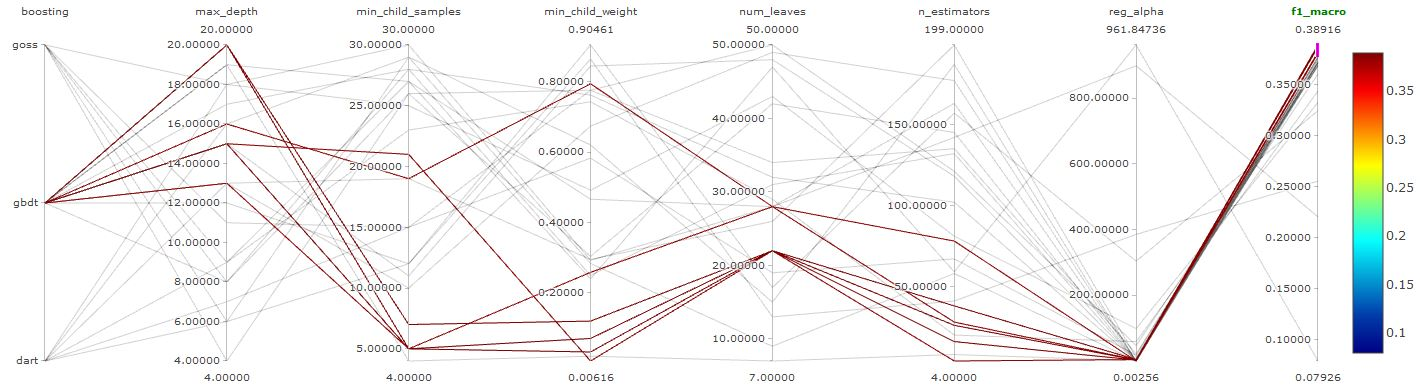

In [14]:
Image(filename='../images/mlflow_2.JPG')

Looks like lower alpha, GBDT, higher max depth


In [15]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 10, 30,1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 4, 200, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50,1)),
    'reg_alpha': hp.loguniform('reg_l1', -10, 2),
    'min_child_weight': hp.uniform('min_child_weight', 0, 1),
    'min_child_samples': scope.int(hp.quniform('min_child_samples',4,30,1)),
    'objective': "multiclass",
    "random_state": 42069,
    "n_jobs": -1,
    "silent": True,
    "num_class": 15
}


In [16]:
with mlflow.start_run(run_name='lightgbm_demo_2'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=25,
    trials=Trials(),
    rstate=np.random.RandomState(42069)
  )


100%|██████████| 25/25 [14:25<00:00, 34.62s/trial, best loss: -0.38771211883122747]


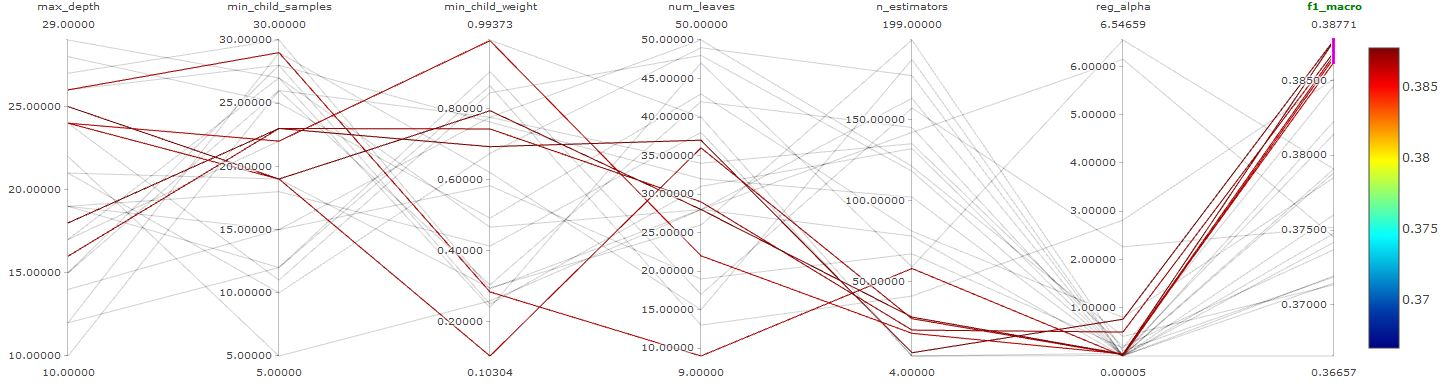

In [17]:
Image(filename='../images/mlflow_3.JPG')

Lower the alpha, increase min child weight and samples


In [18]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 10, 30,1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 4, 200, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50,1)),
    'reg_alpha': hp.uniform('reg_l1', 0, 1),
    'min_child_weight': hp.loguniform('min_child_weight', -10, 2.4),
    'min_child_samples': scope.int(hp.quniform('min_child_samples',4,40,1)),
    'objective': "multiclass",
    "random_state": 42069,
    "n_jobs": -1,
    "silent": True,
    "num_class": 15
}

In [19]:
with mlflow.start_run(run_name='lightgbm_demo_3'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=25,
    trials=Trials(),
    rstate=np.random.RandomState(42069)
  )

100%|██████████| 25/25 [14:51<00:00, 35.66s/trial, best loss: -0.38807227321523297]


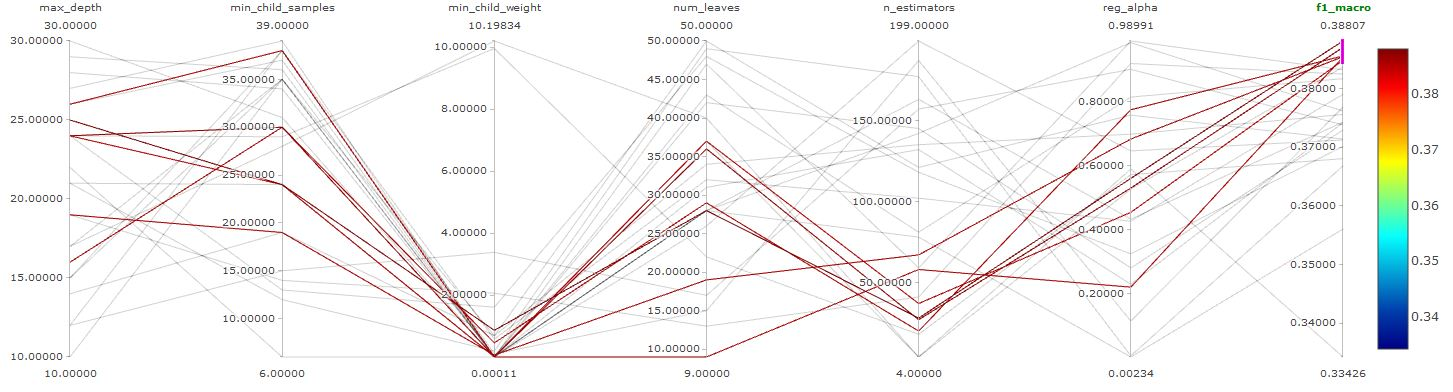

In [20]:
Image(filename='../images/mlflow_4.JPG')


Let's do one more larger run. Lower the n_estimators, lower the min child weight a little, and increase child samples again.


In [21]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 10, 30,1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 4, 100, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50,1)),
    'reg_alpha': hp.uniform('reg_l1', 0, 1),
    'min_child_weight': hp.loguniform('min_child_weight', -10, 0.69),
    'min_child_samples': scope.int(hp.quniform('min_child_samples',10,50,1)),
    'objective': "multiclass",
    "random_state": 42069,
    "n_jobs": -1,
    "silent": True,
    "num_class": 15
}


In [22]:
with mlflow.start_run(run_name='lightgbm_demo_4'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials(),
    rstate=np.random.RandomState(42069)
  )


100%|██████████| 50/50 [14:53<00:00, 17.88s/trial, best loss: -0.39104854783363413]


I think that's a good as it's gonna get.

In [5]:
MODEL = lgb.LGBMClassifier(random_state=42069, objective="multiclass", n_jobs=-1,num_class=15,
                                     max_depth=13, min_child_samples=40,
                                     min_child_weight=0.018708094654384208, n_estimators=43,
                                     num_leaves=17,reg_alpha=0.8704059767213426)


In [24]:
scores = cross_val_score(MODEL, X, Y, cv=5, scoring='f1_macro', n_jobs=-1)


In [25]:
np.mean(scores)


0.39104854783363413

In [6]:
MODEL.fit(X,Y)

LGBMClassifier(max_depth=13, min_child_samples=40,
               min_child_weight=0.018708094654384208, n_estimators=43,
               num_class=15, num_leaves=17, objective='multiclass',
               random_state=42069, reg_alpha=0.8704059767213426)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

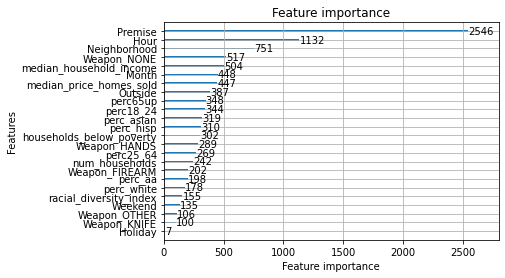

In [7]:
lgb.plot_importance(MODEL)


In [8]:
MODEL.booster_.save_model("DEMO_LGBM_MODEL.txt")